In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [68]:
weight = [263.7, 261.1, 258.5, 258.7, 257.9, 257.1, 256.8, 254.3, 253.9, 251.9, 252.7, 254.7, 254.5, 252.8, 252.8, 258.9, 254.9]
fat = [33.7, 33.1, 32.6, 32.8, 32.5, 32.4, 32.4, 31.9, 31.9, 31.4, 31.6, 32.7, 32.2]
xdata = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19]

In [216]:
def f0g0(x, ar, ai):
    return (ar+ai*1j) * np.ones_like(x)
def f1g0(x, ar, ai, br, bi, cr, ci):
    return (ar+ai*1j) + (br+bi*1j)*np.exp(-(cr+ci*1j)*x)
def f2g0(x, ar, ai, br, bi, cr, ci, dr, di, er, ei):
    return (ar+ai*1j) + (br+bi*1j)*np.exp(-(cr+ci*1j)*x) + (dr+di*1j)*np.exp(-(er+ei*1j)*x)
def f3g0(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi):
    return (ar+ai*1j) + (br+bi*1j)*np.exp(-(cr+ci*1j)*x) + (dr+di*1j)*np.exp(-(er+ei*1j)*x) + \
        (fr+fi*1j)*np.exp(-(gr+gi*1j)*x)
def f3(x, a, b, c, f, g, h, i, j, k):
    return a + b*np.exp(-c*x) + f*np.exp(-g*x)*np.sin(h*x) + i*np.exp(-j*x)*np.cos(k*x)
def f3a(x, a, b, c, f, g, h, k):
    return a + b*np.exp(-c*x) + np.exp(-g*x)*(f*np.sin(h*x) + k*np.cos(h*x))
def f4g0(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii):
    return (ar+ai*1j) + (br+bi*1j)*np.exp(-(cr+ci*1j)*x) + (dr+di*1j)*np.exp(-(er+ei*1j)*x) + \
        (fr+fi*1j)*np.exp(-(gr+gi*1j)*x) + (hr+hi*1j)*np.exp(-(ir+ii*1j)*x)
def f4(x, a, b, c, d, e, f, g, h, i, j, k):
    return a + b*np.exp(-c*x) + d*np.exp(-e*x) + f*np.exp(-g*x)*np.sin(h*x) + i*np.exp(-j*x)*np.cos(k*x)

def fwrap(f, x, *args):
    N = len(x)
    x_real = x[:N//2]
    x_imag = x[N//2:]
    y_real = np.real(f(x_real, *args))
    y_imag = np.imag(f(x_imag, *args))
    return np.hstack([y_real, y_imag])

def f0g(x, ar, ai):
    return fwrap(f0g0, x, ar, ai)
def f1g(x, ar, ai, br, bi, cr, ci):
    return fwrap(f1g0, x, ar, ai, br, bi, cr, ci)
def f2g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei):
    return fwrap(f2g0, x, ar, ai, br, bi, cr, ci, dr, di, er, ei)
def f3g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi):
    return fwrap(f3g0, x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi)
def f4g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii):
    return fwrap(f4g0, x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii)

def j0g0(x, ar, ai):
    jac = [np.ones_like(x), np.ones_like(x)*1j]
    return np.array(jac).T
def j1g0(x, ar, ai, br, bi, cr, ci):
    jac = [np.ones_like(x), np.ones_like(x)*1j,
           np.exp(-(cr+ci*1j)*x), np.exp(-(cr+ci*1j)*x)*1j,
           -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x), -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x)*1j]
    return np.array(jac).T
def j2g0(x, ar, ai, br, bi, cr, ci, dr, di, er, ei):
    jac = [np.ones_like(x), np.ones_like(x)*1j,
           np.exp(-(cr+ci*1j)*x), np.exp(-(cr+ci*1j)*x)*1j,
           -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x), -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x)*1j,
           np.exp(-(er+ei*1j)*x), np.exp(-(er+ei*1j)*x)*1j,
           -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x), -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x)*1j]
    return np.array(jac).T
def j3g0(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi):
    jac = [np.ones_like(x), np.ones_like(x)*1j,
           np.exp(-(cr+ci*1j)*x), np.exp(-(cr+ci*1j)*x)*1j,
           -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x), -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x)*1j,
           np.exp(-(er+ei*1j)*x), np.exp(-(er+ei*1j)*x)*1j,
           -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x), -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x)*1j,
           np.exp(-(gr+gi*1j)*x), np.exp(-(gr+gi*1j)*x)*1j,
           -(fr+fi*1j)*x*np.exp(-(gr+gi*1j)*x), -(fr+fi*1j)*x*np.exp(-(gr+gi*1j)*x)*1j]
    return np.array(jac).T
def j3a(x, a, b, c, f, g, h):
    jac = [np.ones_like(x),
           np.exp(-c*x),
           -b*x*np.exp(-c*x),
           np.exp(-g*x)*(np.sin(h*x) + np.cos(h*x)),
           -f*x*np.exp(-g*x)*(np.sin(h*x) + np.cos(h*x)),
           f*x*np.exp(-g*x)*(np.cos(h*x) - np.sin(h*x))]
    return np.array(jac).T
def j4g0(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii):
    jac = [np.ones_like(x), np.ones_like(x)*1j,
           np.exp(-(cr+ci*1j)*x), np.exp(-(cr+ci*1j)*x)*1j,
           -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x), -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x)*1j,
           np.exp(-(er+ei*1j)*x), np.exp(-(er+ei*1j)*x)*1j,
           -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x), -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x)*1j,
           np.exp(-(gr+gi*1j)*x), np.exp(-(gr+gi*1j)*x)*1j,
           -(fr+fi*1j)*x*np.exp(-(gr+gi*1j)*x), -(fr+fi*1j)*x*np.exp(-(gr+gi*1j)*x)*1j,
           np.exp(-(ir+ii*1j)*x), np.exp(-(ir+ii*1j)*x)*1j,
           -(hr+hi*1j)*x*np.exp(-(ir+ii*1j)*x), -(hr+hi*1j)*x*np.exp(-(ir+ii*1j)*x)*1j]
    return np.array(jac).T

def jwrap(j, x, *args):
    N = len(x)
    x_real = x[:N//2]
    x_imag = x[N//2:]
    y_real = np.real(j(x_real, *args))
    y_imag = np.imag(j(x_imag, *args))
    return np.concatenate([y_real, y_imag], axis=0)

def j0g(x, ar, ai):
    return jwrap(j0g0, x, ar, ai)
def j1g(x, ar, ai, br, bi, cr, ci):
    return jwrap(j1g0, x, ar, ai, br, bi, cr, ci)
def j2g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei):
    return jwrap(j2g0, x, ar, ai, br, bi, cr, ci, dr, di, er, ei)
def j3g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi):
    return jwrap(j3g0, x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi)
def j4g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii):
    return jwrap(j4g0, x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii)

In [226]:
wopt0g, _ = curve_fit(f0g, np.hstack([xdata, xdata]), np.hstack([np.real(weight), np.imag(weight)]), jac=j0g, maxfev=1000000)
print(f"wopt0g={wopt0g}")
wopt1g, _ = curve_fit(f1g, np.hstack([xdata, xdata]), np.hstack([np.real(weight), np.imag(weight)]), jac=j1g, maxfev=1000000)
print(f"wopt1g={wopt1g}")
wopt2g, _ = curve_fit(f2g, np.hstack([xdata, xdata]), np.hstack([np.real(weight), np.imag(weight)]), jac=j2g, maxfev=1000000)
print(f"wopt2g={wopt2g}")
wopt3g, _ = curve_fit(f3g, np.hstack([xdata, xdata]), np.hstack([np.real(weight), np.imag(weight)]), jac=j3g, maxfev=1000000)
print(f"wopt3g={wopt3g}")
wopt3, _ = curve_fit(f3, xdata, weight, maxfev=1000000)
print(f"wopt3={wopt3}")
wopt3a, _ = curve_fit(f3a, xdata, weight, maxfev=1000000)
print(f"wopt3a={wopt3a}")
wopt4g, _ = curve_fit(f4g, np.hstack([xdata, xdata]), np.hstack([np.real(weight), np.imag(weight)]), jac=j4g, maxfev=1000000)
print(f"wopt4g={wopt4g}")
wopt4, _ = curve_fit(f4, xdata, weight, maxfev=1000000)
print(f"wopt4={wopt4}")

wopt0g=[2.56188235e+02 3.88578059e-16]
wopt1g=[2.54100508e+02 1.95131384e-05 9.74753640e+00 1.13589075e-05
 3.18487868e-01 4.10009816e-06]
wopt2g=[ 2.58000077e+02  3.48871664e-03  2.42810759e+00 -3.18846718e+00
  4.54127103e-02  1.81259273e-01  2.42193669e+00  3.18512576e+00
  4.52618184e-02 -1.81329485e-01]
wopt3g=[ 2.57807119e+02 -7.60675485e+00 -3.89069071e-01 -1.50616510e+00
 -5.08377409e-02  2.05188270e-01  5.45612482e+00  9.03945096e+00
  5.00043559e-02 -9.58302438e-02  7.20793081e-02  3.28123275e-03
 -2.21530221e-01 -1.09902451e+00]


C:\Users\watso\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\watso\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\watso\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\watso\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()


wopt3=[ 6.73274276e+04 -6.70649303e+04 -1.69702966e-05 -1.33932654e-02
 -5.40843091e-01  4.76923220e-01  1.66318818e-03 -6.72926221e-01
 -3.99728830e-01]
wopt3a=[ 2.52177245e+02  1.11958020e+01  1.99764976e-01 -1.35877095e-16
 -2.17219254e+00 -4.85047888e-01  2.57916521e-17]


C:\Users\watso\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


wopt4g=[ 2.59064784e+02 -1.89338379e+00  6.39755408e-01 -6.25460014e-01
  6.44294095e-02  1.02126233e+00  2.27448783e+00 -1.75575653e+00
  3.38205374e-02  2.50677464e-01  1.27973376e+00  4.34893882e+00
  6.22649052e-03 -1.38566485e-01  7.95487912e-02 -4.44783699e-03
 -2.11302167e-01 -1.10466374e+00]


C:\Users\watso\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


wopt4=[-1.10955476e+03  4.46474738e+00  5.55496351e-01  1.36880041e+03
  4.09661885e-04 -5.69885756e-01 -9.49870589e-02  9.51641362e-01
  5.43210413e-02 -2.93230187e-01 -3.99012775e-01]


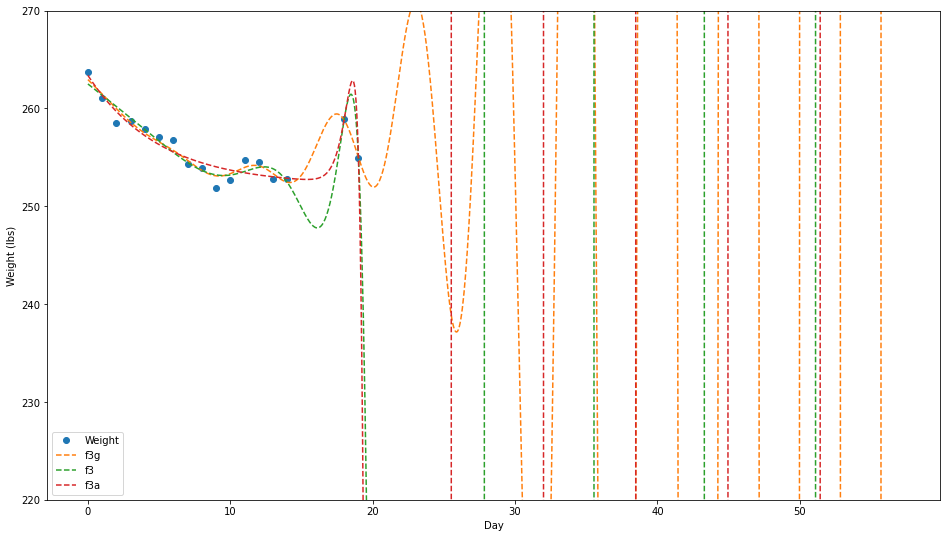

In [227]:
fig = plt.figure(figsize=(16, 9))
x = np.linspace(0, 3 * xdata[-1], 1000)
plt.plot(xdata, weight, 'o', label='Weight')
#plt.plot(x, np.real(f0g0(x, *wopt0g)), '--', label='f0')
#plt.plot(x, np.real(f1g0(x, *wopt1g)), '--', label='f1')
#plt.plot(x, np.real(f2g0(x, *wopt2g)), '--', label='f2')
plt.plot(x, np.real(f3g0(x, *wopt3g)), '--', label='f3g')
plt.plot(x, np.real(f3(x, *wopt3)), '--', label='f3')
plt.plot(x, np.real(f3a(x, *wopt3a)), '--', label='f3a')
#plt.plot(x, np.real(f4g0(x, *wopt4g)), '--', label='f4g')
#plt.plot(x, np.real(f4(x, *wopt4)), '--', label='f4')
plt.xlabel('Day')
plt.ylabel('Weight (lbs)')
plt.ylim((220, 270))
plt.legend()
plt.show()